In [296]:
import csv
from io import StringIO
from pprint import pprint
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pytesseract
from skimage import io, color
from skimage.filters import threshold_otsu
from skimage.feature import canny

from py_stringmatching.similarity_measure.needleman_wunsch import NeedlemanWunsch

from IPython.display import display

In [80]:
fl = 'clonehero-Flatline-20211207210200.png'
vis = '/home/james/.config/Clone Hero Launcher/gameFiles/Screenshots/clonehero-Visions-20211208205916.png'

In [297]:
NW = NeedlemanWunsch()

In [105]:
# Constants that match the format given by tesseract
LEFT = 0
TOP = 1
W = 2
H = 3

In [184]:
# Constants for internal "quadrant" nonsense
QLEFT_KEY = 0
QLEFT_VAL = 1
QRIGHT_KEY = 2
QRIGHT_VAL = 3

In [319]:
# Constants for raw song data dictionary keys
BREAKDOWN = 'song_breakdown'
STATKEYS = 'stat_keys'

In [295]:
# Stat names/keys
KNOWN_STATS = [
    'difficulty',
    'score',
    'stars',
    'accuracy',
    'highest streak',
    'sp earned',
    'avg. multiplier',
    'modifiers',
    'gamepad mode',
]

In [3]:
# Loads pixels from file and returns them
def load(name, preprocess=True):
    pic = io.imread(name)
    
    if preprocess:
        # we need a grayscale image for the next operation 
        # note that this implicitly converts from 3D to 2D
        bw = color.rgb2gray(pic)

        # use a computer-determined threshold to label "background" pixels
        # as False and other pixels as True.
        thresh = threshold_otsu(bw)
        thresholded = (bw >= thresh)

        # apply threshold list to picture - values in "pic" will be set to 0
        # if their corresponding value in "thresholded" is False
        pic = np.atleast_3d(thresholded) * pic

    return pic

In [4]:
# displays pixels
def disp(fig):
    plt.figure(figsize=(16,9), dpi=100)
    io.imshow(fig)

In [5]:
names = ['left', 'top', 'width', 'height']

# convert boxes coordinates to something prettier
def printboxes(boxes, df, dropna=True):
    df2 = pd.DataFrame(boxes, columns=names)
    ret = pd.merge(df, df2, on=names)
    if dropna:
        ret = ret.dropna()
    return ret

# convert boxes coordinates to something prettier
def printboxesdict(data, df, dropna=True):
    for k, v in data.items():
        mdf = pd.merge(df, pd.DataFrame([v], columns=names)).dropna()
        text = list(mdf['text'])[0]
        print(f'{k}: {text}')

In [219]:
box = [602, 0, 0, 14]
l, t, w, h = box
#sel = df[(df['left'] == l) & (df['top'] == t) & (df['width'] == w) & (df['height'] == h)]
sel = df[(df['left'] == l) & (df['height'] == h)]
display(sel['text'].dropna())
print(' '.join(sel['text'].dropna()))
df.dropna().head(10)

20    Score
28       SP
Name: text, dtype: object

Score SP


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,214,70,124,29,91,Flatline
6,5,1,1,1,2,1,213,121,125,27,87,Periphery
8,5,1,1,1,3,1,213,167,120,22,88,Bloodline
12,5,1,2,1,1,1,213,211,57,57,95,
16,5,1,3,1,1,1,603,469,82,18,75,Difficulty
20,5,1,4,1,1,1,602,510,49,14,88,Score
24,5,1,5,1,1,1,602,590,82,17,84,Accuracy
28,5,1,6,1,1,1,602,670,22,14,90,SP
29,5,1,6,1,1,2,631,669,60,15,79,Earned
33,5,1,7,1,1,1,603,749,84,15,79,Modifiers


In [220]:
def boxText(box, df):
    l, t, w, h = box
    sel = df[(df['left'] == l) & (df['top'] == t) & (df['width'] == w) & (df['height'] == h)]
    return ' '.join(sel['text'].dropna())
    return sel.iloc[0]['text']

In [89]:
def dispboxes(img, boxes, df):
    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(img)

    for l, t, w, h in boxes:
        rect = patches.Rectangle((l, t), w, h, edgecolor='r', alpha=0.5)
        ax.add_patch(rect)
    return fig

In [7]:
# Returns a list that is a subset of @boxes but filtered so that each
# returned box is within the specified range of x and y values.
# Note that x and y values are specified from 0 to 1.
def filterBoxes(img, boxes, xmin=0, xmax=1, ymin=0, ymax=1):
    img_w = len(img[0])
    img_h = len(img)
    
    assert xmin >= 0
    assert ymin >= 0
    assert xmax <= 1
    assert ymax <= 1

    calc_xmin = img_w * xmin
    calc_xmax = img_w * xmax
    calc_ymin = img_h * ymin
    calc_ymax = img_h * ymax
    
    filt_boxes = [
        (left, top, w, h)
        for left, top, w, h in boxes
        if (
            left   >= calc_xmin and
            top    >= calc_ymin and
            left+w <= calc_xmax and
            top+h  <= calc_ymax
        )
    ]
    return filt_boxes

In [106]:
# returns 1 big box that covers all the input boxes
def combineBoxes(boxes):
    box_left = min(map(lambda x: x[LEFT], boxes))
    box_top = min(map(lambda x: x[TOP], boxes))

    box_right = max(map(lambda x: x[LEFT]+x[W], boxes))
    box_bottom = max(map(lambda x: x[TOP]+x[H], boxes))

    box_w = box_right - box_left
    box_h = box_bottom - box_top

    return (box_left, box_top, box_w, box_h)

In [281]:
# This function looks for boxes with similar coordinates, depending on
# what the user wants.
# This type of function is designed to filter out any type of unexpected
# noise. This currently comes at the expense of having sane-looking code.
#
# @boxes:   list of box coordinates
# @idx:     index of box coordinates to compare
# @tol:     tolerance/allowable deviation in pixels
# @n:       expected number of elements (or an exception will be raised)
# @matches: expected number of matches (-1 for all matches)
def groupByBoxData(boxes, idx, tol, n, matches=1):
    candidates = []
    for box_list in combinations(boxes, n):
        lefts = [box[idx] for box in box_list]
        total = sum(lefts)
        avg = total/len(lefts)
        for box in box_list:
            if abs(box[idx] - avg) > tol:
                break
        else:
            candidates.append(box_list)
        
    if not candidates:
        raise ValueError('no valid grouping found')
    if matches != -1 and len(candidates) > matches:
        raise RuntimeError('too many boxes detected')
    return candidates

In [279]:
def groupByLeft(boxes, tol, n, **kwargs):
    return groupByBoxData(boxes, LEFT, tol, n, **kwargs)

In [108]:
def groupByTop(boxes, tol, n, **kwargs):
    return groupByBoxData(boxes, TOP, tol, n, **kwargs)

In [283]:
# These boxes are in the top left. We hope to find 4 pieces of info:
# - song name (text)
# - song artist (text)
# - song composer (text)
# - song source (img)
def getSongInfo(img, boxes, df):
    fields = ['song_name', 'song_artist', 'song_composer', 'song_source']
    exp_len = len(fields)
    ret = {key:None for key in fields}
    
    filtered = filterBoxes(img, boxes, xmax=.3, ymax=.4)
    
    # We've got everything in the top left at this point, now we need to
    # filter out potential noise and parse the results.
    try:
        # Ideally this returns a valid group of 4 boxes
        group = groupByLeft(filtered, 10, exp_len)[0]
    except RuntimeError:
        # This situation is confusing, so let's bail
        return ret
    except ValueError:
        # There don't appear to be 4 valid boxes, so let's assume 1 is missing
        try:
            group = groupByLeft(filtered, 10, exp_len-1)[0]
        except Exception as e:
            # We tried...
            return ret
        
        # At this point we have 3 elements. We need to figure out which is missing
        # so that we can successfully assign data below.
        #raise RuntimeError('MISSING DATA: need to implement workaround')
        return ret
        
    # Order by starting height
    sgroup = sorted(group, key=lambda x: x[TOP])
    
    # Correlate box coordinates with text in input dataframe
    for field, box in zip(fields, sgroup):
        ret[field] = (boxText(box, df), box)
        
    return ret

In [140]:
def getVersion(img, boxes, df):
    filtered = filterBoxes(img, boxes, xmin=.7, ymax=.1)

    # we generally expect 3 boxes, ex: "Clone", "Hero", "v1.0.0.3075-master"
    # we'll just concatenate however many we can.
    exp_len = 3
    while exp_len > 1:
        try:
            group = groupByTop(filtered, 10, exp_len)[0]
        except RuntimeError:
            return {}
        except ValueError:
            exp_len -= 1
            continue
        break
    else:
        raise RuntimeError('idk')

    # Order by 'left' coordinate
    sgroup = sorted(group, key=lambda x: x[LEFT])

    # Correlate box coordinates with text in input dataframe
    version = []
    version_boxes = []
    for box in sgroup:
        version.append(boxText(box, df))
        version_boxes.append(box)
        
    version_box = combineBoxes(version_boxes)

    return {'version': (' '.join(version), version_box)}

In [290]:
def getScore(img, boxes, df):
    filtered = filterBoxes(img, boxes, xmin=.4, xmax=.6, ymax=.4)
    
    #
    # Case #1: just the score is present
    #
    if len(filtered) == 1:
        #left, top, w, h = filtered[0]
        #sel = df[(df['left'] == left) & (df['top'] == top) & (df['width'] == w) & (df['height'] == h)].dropna()
        #score = sel.iloc[0]['text']
        score = boxText(filtered[0], df)
        return {'score': (score, filtered[0]), 'high_score': False} 
    
    # convert to set so we can use set logic
    filtered_set = set(filtered)
    assert len(filtered_set) == len(filtered)

    #
    # Case #2: the score is present as well as a "New High Score!" message
    #
    if len(filtered_set) == 4:
        # Look for group of 3 boxes ("New", "High", "Score")
        exp_len = 3
        try:
            group = groupByTop(filtered, 10, exp_len)[0]
            group_set = set(group)
        except RuntimeError:
            # we could do more work to figure out what IS the score
            return {}
        except ValueError:
            # we could do more work to figure out what IS the score
            return {}
        
        score_box = (filtered_set - group_set).pop()

        #left, top, w, h = score_box
        #sel = df[(df['left'] == left) & (df['top'] == top) & (df['width'] == w) & (df['height'] == h)].dropna()
        #score = sel.iloc[0]['text']
        score = boxText(score_box, df)
        
        hs_box = combineBoxes(group)
        
        return {'score_top': (score, score_box), 'high_score': (True, hs_box)}

    return {}

In [145]:
# called by getMiddleData
def getTopMiddleRow(img, boxes, df):
    try:
        return {
            'username': boxText(boxes[0], df),
            'icons': boxText(boxes[1], df),
        }
    except IndexError:
        return {}

In [195]:
# helper to getMiddleBody
def getQuadrant(box, left_mid, middle, right_mid):
    box_mid = box[LEFT]+box[W]/2
    if box_mid < left_mid:
        return QLEFT_KEY
    elif box_mid < middle:
        return QLEFT_VAL
    elif box_mid < right_mid:
        return QRIGHT_KEY
    else:
        return QRIGHT_VAL

In [286]:
# called by getMiddleData
# @box_lists is a sorted list of sorted lists of boxes
def getMiddleBody(img, box_lists, df):
    # Get lists of left-most and right-most points for each row. This
    # will be used to establish a halfway point along the x axis.
    # Note that this value will be around the length of the screen/2...
    ls = []
    rs = []
    for box_list in box_lists:
        ls.append(box_list[0][LEFT])
        rs.append(box_list[-1][LEFT] + box_list[-1][W])
        
    # Sort lists so that we can get the median. We use the median to
    # figure out the halfway point because we assume most boxes are
    # present in the tesseract data
    ls = sorted(ls)
    rs = sorted(rs)
    
    med_l = ls[int(len(ls)/2)]
    med_r = rs[int(len(rs)/2)]
    middle = med_l + (med_r-med_l)/2
    
    # The data we need is split up into 2 halves, each of which have 2
    # columns. We can now use the middle point from above to calculate
    # the halfway points of these 2 halves so that we can determine where
    # individual boxes are located.
    left_mid = med_l + (middle-med_l)/2
    right_mid = middle + (med_r-middle)/2

    # Now that we have the data we need we can tag each box as being in
    # one of four "quadrants" (columns). Create new box_quads structure
    # for this purpose. It is a list of lists of lists of boxes - it
    # basically just splits box_list by quadrant.

    box_quads = []
    for box_list in box_lists:
        curr_quads = [[] for _ in range(4)]
        for box in box_list:
            quadrant = getQuadrant(box, left_mid, middle, right_mid)
            curr_quads[quadrant].append(box)
        box_quads.append(curr_quads)

    ret = {}
    ret[BREAKDOWN] = {} # song breakdown is nested
    ret[STATKEYS] = [] # list of stats will be used by downstream code
    
    # For clarity, each @box_quad_list is a list of length 4 where each entry
    # in the list is a list of boxes present in the respective quadrant.
    # We need to get the text from all list of boxes as well as the total box
    # area represented per quadrant.
    for rownum, box_quad_list in enumerate(box_quads):
        for quad, boxes in enumerate(box_quad_list):
            # Normal case: we were able to find data
            if boxes:
                text = ' '.join(boxText(box, df) for box in boxes)
                #print(f'Iter: {quad}. Num_boxes: {len(boxes)}')
                #print(f'{comb_box}: {text}')

                # Grab the value and keep iterating.
                if quad == QLEFT_KEY or quad == QRIGHT_KEY:
                    curr_key = text
                    continue

                comb_box = combineBoxes(boxes)
                
                # Assign the value to the return dict
                if quad == QLEFT_VAL:
                    ret[curr_key] = (text, comb_box)
                    ret[STATKEYS].append(curr_key)
                elif quad == QRIGHT_VAL:
                    ret[BREAKDOWN][curr_key] = (text, comb_box)

            # Error case: data was not read in by OCR
            else:
                if quad == QLEFT_KEY or quad == QRIGHT_KEY:
                    curr_key = f'missing_{rownum}'
                elif quad == QLEFT_VAL:
                    ret[curr_key] = ('MISSING', None)
                    ret[STATKEYS].append(curr_key)
                elif quad == QRIGHT_VAL:
                    # If both the key and value are missing we do nothing due
                    # to the fact that some songs have fewer breakdown sections
                    # than stats.
                    if not curr_key.startswith('missing'):
                        ret[BREAKDOWN][curr_key] = ('MISSING', None)
            

    return ret

In [175]:
def getMiddleData(img, boxes, df, tol=10):
    ret = {}
    
    filtered = filterBoxes(img, boxes, xmin=.25, xmax=.75, ymin=.3, ymax=.85)
    
    # Sort by y axis
    filtered = sorted(filtered, key=lambda x: x[TOP])
    
    groups = []
    curr_group = []
    prev_y = filtered[0][TOP]
    
    # Group boxes by their location on the y axis
    for box in filtered:
        curr_y = box[TOP]

        # Group is finalized if there was a jump in y value
        if (curr_y - prev_y) > tol:
            groups.append(sorted(curr_group, key=lambda x: x[LEFT]))
            curr_group = [box]
        else:
            curr_group.append(box)
        prev_y = curr_y

    # Don't forget the last entry
    groups.append(sorted(curr_group, key=lambda x: x[LEFT]))

    # First group is its own row
    ret.update(getTopMiddleRow(img, groups[0], df))
    
    # Get the meat of the data
    ret.update(getMiddleBody(img, groups[1:], df))

    return ret

In [169]:
#global_garbage

In [197]:
# When extracting information from images our general approach is to break
# down the image into pieces and figure out data from the narrowed set of
# pixels.
def get_raw_data(img, data, input_df):
    img_w = len(img[0])
    img_h = len(img)
    img_size = img_w * img_h
    
    processed_data = {}
    
    # pytesseract includes NaNs where text wasn't found...we don't need them
    df = input_df.dropna()
    all_boxes = set(zip(df['left'], df['top'], df['width'], df['height']))
    
    # Filter out:
    # - an expected box the entire size of the image
    # - potential noise
    search_boxes = [box for box in all_boxes if box[W]*box[H] < img_size/2]

    # Get basic song info
    song_info = getSongInfo(img, search_boxes, input_df)
    processed_data.update(song_info)
    
    # TODO: convert source location to valid value
    #source_location = song_info['song_source'][1]
    
    # Get game version
    version = getVersion(img, search_boxes, input_df)
    processed_data.update(version)
    
    # Get score
    score = getScore(img, search_boxes, input_df)
    processed_data.update(score)
    
    # Get everything else in the middle of the screen
    middle = getMiddleData(img, search_boxes, input_df)
    processed_data.update(middle)
    
    #print(len(all_boxes))
    #print(len(search_boxes))
    return processed_data

In [298]:
# heuristic
def similar_strings(left, right):
    nw_val = NW.get_raw_score(left, right)
    avg_len = (len(left)+len(right)) / 2
    if nw_val > avg_len/2:
        return True
    return False

In [323]:
def getAdjacentIndices(idx, length):
    if idx == 0:
        return 1,2
    
    if idx == length-1:
        return idx-3, idx-2
    
    return idx-1, idx+1

In [321]:
# attempts to standardize the data
def clean_data(data):
    known_stats = list(KNOWN_STATS) # make a copy so we can modify it
    
    #
    # Loop through all stats OCR was able to read in and correct
    # them to stats that we know about and have hard-coded.
    #
    for i, obs in enumerate(data[STATKEYS]):
        obs_cl = obs.lower().strip()

        # Look for a matching expected key
        for exp in known_stats:
            if obs_cl == exp or similar_strings(exp, obs_cl):
                corrected = exp
                break
        else:
            # Missing data or new format of data (which means the code needs an update)
            continue

        # Nothing to do
        if corrected == obs: 
            continue

        # Rename the key
        data[corrected] = data[obs]
        del data[obs]
        
        data[STATKEYS][i] = corrected

        known_stats.remove(corrected)

    #
    # Try and fix "missing" stats, which occur when OCR didn't read in
    # a key.
    #
    for obs in data[STATKEYS]:
        if not obs.startswith('missing'):
            continue
            
        # Locate stats to the left
        #if obs_idx > 0:
        #    prev_val = data[STATKEYS][obs_idx-1]
        #else:
        #    prev_val = None
            
        #if obs_idx < len(data[STATKEYS]):
        #    next_val = data[STATKEYS][obs_idx+1]
        #else:
        #    next_val = None
            
        #trio = (prev_val, obs, next_val)
        
        obs_idx = data[STATKEYS].index(obs)
        idx2, idx3 = getAdjacentIndices(obs_idx, len(data[STATKEYS]))
        val2, val3 = data[STATKEYS][idx2], data[STATKEYS][idx3]
        
        # Create expected list of 3
        exp_trio = []
        start_idx = max(obs_idx-1, 0)

        while len(exp_trio) < 3:

    # They've served their purpose
    #del data[STATKEYS]

    return data

In [288]:
#data = pytesseract.image_to_data(fl) # can load from filename

#img = load(fl, preprocess=False)
img = load(fl)
#img2 = load(vis)

data = pytesseract.image_to_data(img)
#data2 = pytesseract.image_to_data(img2)

df = pd.read_csv(StringIO(data), sep='\t', quoting=csv.QUOTE_NONE)
#df2 = pd.read_csv(StringIO(data2), sep='\t', quoting=csv.QUOTE_NONE)

df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1920,1080,-1,NaN
1,2,1,1,0,0,0,213,70,125,119,-1,NaN
2,3,1,1,1,0,0,213,70,125,119,-1,NaN
3,4,1,1,1,1,0,214,70,124,29,-1,NaN
4,5,1,1,1,1,1,214,70,124,29,91,Flatline
...,...,...,...,...,...,...,...,...,...,...,...,...
131,3,1,16,1,0,0,1537,14,349,19,-1,NaN
132,4,1,16,1,1,0,1537,14,349,19,-1,NaN
133,5,1,16,1,1,1,1537,14,63,19,85,Clone
134,5,1,16,1,1,2,1610,15,51,18,89,Hero


In [322]:
b = get_raw_data(img, data, df)
b = clean_data(b)
pprint(b)

#print()
#c = get_raw_data(img2, data2, df2)
#pprint(c)

{'accuracy': ('2253/2389 [94%)', (739, 589, 151, 18)),
 'avg. multiplier': ('2‘411x', (833, 710, 58, 15)),
 'difficulty': ('Expert', (837, 470, 54, 18)),
 'gamepad mode': ('Off', (864, 790, 27, 15)),
 'high_score': (True, (830, 126, 261, 33)),
 'highest streak': ('158', (859, 630, 31, 15)),
 'icons': '3C5)',
 'missing_2': ('4', (880, 550, 11, 14)),
 'modifiers': ('2x Kick', (831, 750, 60, 14)),
 'score': ('287,950', (819, 510, 72, 16)),
 'score_top': ('287,950', (865, 69, 191, 45)),
 'song_artist': ('Periphery', (213, 121, 125, 27)),
 'song_breakdown': {'Bridge 1': ('91%', (1282, 630, 36, 15)),
                    'Bridge la': ('89%', (1281, 670, 37, 15)),
                    'Chorus 1': ('94%', (1282, 750, 36, 15)),
                    'Chorus 13': ('87%', (1281, 790, 37, 15)),
                    'Main riff 1': ('96%', (1282, 470, 36, 15)),
                    'Post-verse 1': ('97%', (1282, 590, 36, 15)),
                    'Pre-chorus 1': ('89%', (1281, 710, 37, 15)),
             

In [59]:
c = [(914, 126, 69, 33), (996, 127, 95, 26), (865, 69, 191, 45), (830, 127, 70, 26)]
printboxes(c, df)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
3,5,1,11,1,1,1,865,69,191,45,87,"287,950"
4,5,1,12,1,1,1,830,127,70,26,89,New
5,5,1,12,1,1,2,914,126,69,33,86,High
6,5,1,12,1,1,3,996,127,95,26,85,Score!


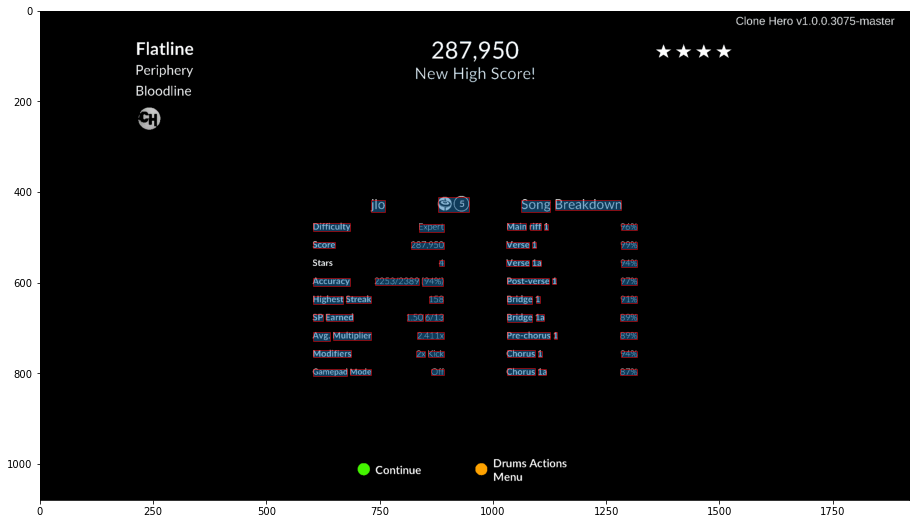

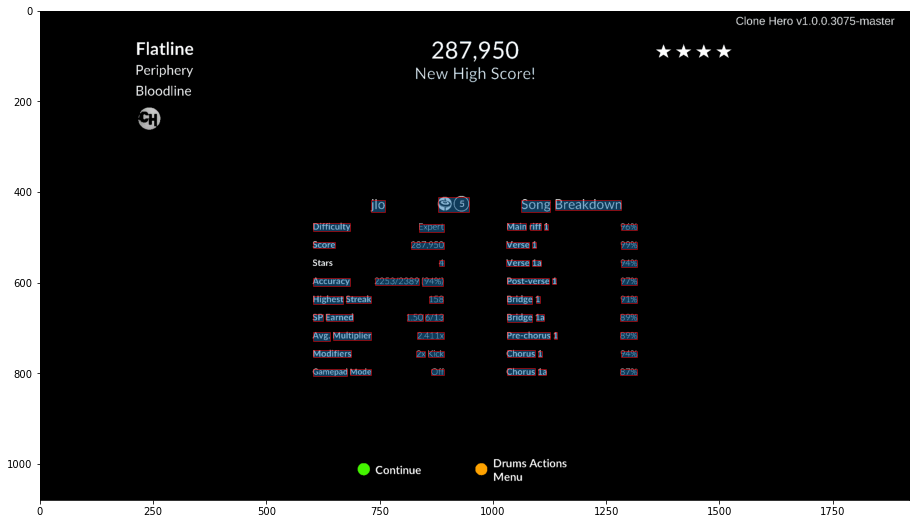

In [124]:
c = [(810, 670, 35, 15), (1282, 630, 36, 15), (603, 629, 67, 19), (859, 630, 31, 15), (864, 790, 27, 15), (851, 670, 39, 15), (685, 790, 46, 14), (857, 750, 34, 14), (1087, 550, 19, 14), (602, 790, 76, 16), (1030, 749, 62, 15), (1081, 469, 25, 15), (1087, 510, 9, 14), (1282, 510, 36, 15), (1094, 630, 9, 14), (1031, 669, 56, 19), (1113, 470, 9, 14), (1282, 590, 36, 15), (1031, 469, 42, 15), (1282, 470, 36, 15), (602, 590, 82, 17), (1094, 670, 19, 14), (1281, 790, 37, 15), (603, 469, 82, 18), (602, 710, 38, 18), (843, 589, 47, 18), (1134, 710, 8, 14), (675, 629, 56, 15), (1099, 790, 19, 14), (1063, 417, 64, 27), (1138, 417, 145, 22), (880, 550, 11, 14), (833, 710, 58, 15), (602, 670, 22, 14), (1282, 750, 36, 15), (1029, 550, 51, 14), (1030, 789, 62, 15), (837, 470, 54, 18), (1029, 510, 51, 14), (1031, 590, 93, 14), (1131, 590, 9, 14), (1281, 670, 37, 15), (1282, 550, 36, 15), (739, 590, 97, 15), (1281, 710, 37, 15), (602, 510, 49, 14), (819, 510, 72, 16), (878, 410, 69, 34), (1031, 629, 56, 19), (1031, 709, 95, 15), (647, 709, 84, 18), (831, 750, 19, 14), (631, 669, 60, 15), (1099, 750, 9, 14), (603, 749, 84, 15), (730, 417, 31, 27)]
#printboxes(c, df)
dispboxes(img, c, df)
#printboxesdict(b, df)

In [123]:
#gg = [val for sublist in global_garbage for val in sublist]
#dispboxes(img, gg, df)

In [312]:
asdf=[70, 121, 167, 211]
a,b,c,d = asdf
print(b-a)
print(c-b)
print(d-c)

51
46
44


In [122]:
#df['block_num'].value_counts()

In [177]:
# displays rectangles given by tesseract
# user can filter by block numbers if desired
def dispboxes(img, data, bns=[]):
    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(img)
    
    # quoting argument allows for quotes in the data (noise?) to be read in literally
    df = pd.read_csv(StringIO(data), sep='\t', quoting=csv.QUOTE_NONE)
    
    s = set(zip(df['left'], df['top'], df['width'], df['height'], df['block_num']))
    total_size = len(img) * len(img[0])

    for l, t, w, h, bn in s:
        if bns and bn not in bns:
            continue

        # don't plot anything that will take up over half the image
        if (w*h) >= total_size/2:
            continue
        
        rect = patches.Rectangle((l, t), w, h, edgecolor='r', alpha=0.5)
        ax.add_patch(rect)
    
    return df

def dispedges(img):
    disp(canny(color.rgb2gray(img)))

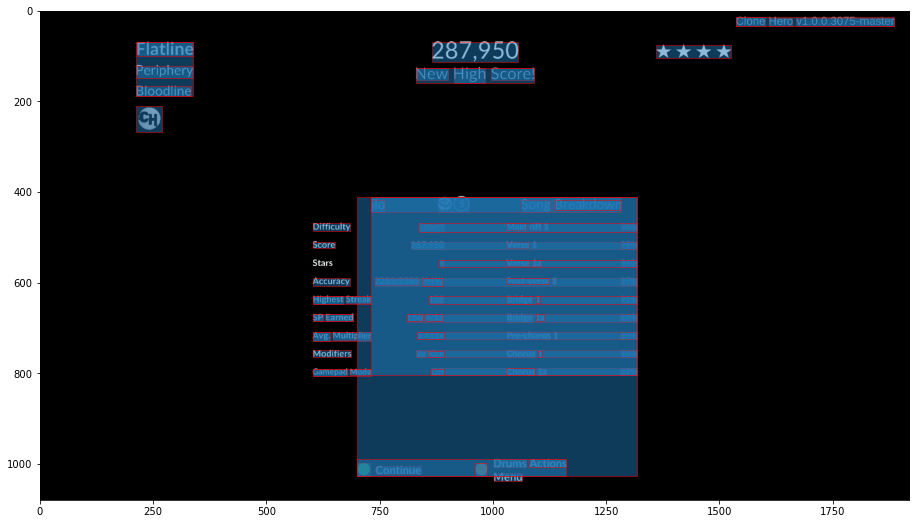

In [167]:
#dispboxes(img, data, bns=None);

In [179]:
#dispboxes(img2, data2, bns=[4,5,6]);

In [180]:
#dispedges(img)

In [198]:
def getCoords(img, tokens):
    if 'left' in tokens:
        minx = 0
        maxx = int(len(img[0])*1/3)
    elif 'right' in tokens:
        minx = int(len(img[0])*2/3)
        maxx = len(img[0])
    elif 'center' in tokens:
        minx = int(len(img[0])*1/3)
        maxx = int(len(img[0])*2/3)
        
    if 'top' in tokens:
        miny = 0
        maxy = int(len(img)*1/3)
    elif 'bottom' in tokens:
        miny = int(len(img)*2/3)
        maxy = len(img)
    elif 'center' in tokens:
        miny = int(len(img)*1/3)
        maxy = int(len(img)*2/3)

    return minx, maxx, miny, maxy

def belongs(img, square, which):
    tokens = set(which.split())

    left, top, w, h = square
    
    # Validate input crudely
    if tokens not in [
        {'top', 'left'},    {'top', 'center'},    {'top', 'right'},
        {'center', 'left'}, {'center', 'center'}, {'center', 'right'},
        {'bottom', 'left'}, {'bottom', 'center'}, {'bottom', 'right'},
        {'center'},
    ]:
        raise ValueError(f'Invalid location: {which}')
        
    minx, maxx, miny, maxy = getCoords(img, tokens)
    
    if left < minx:
        return False
    if top < miny:
        return False
    if left+w > maxx:
        return False
    if top+h > maxy:
        return False
    return True

In [197]:
getCoords(img, 'center bottom')

(640, 1280, 720, 1080)

In [207]:
def allSquares(df):
    return set(zip(df['left'], df['top'], df['width'], df['height']))
        
# Example @which: 'top left', 'center', 'bottom center'
def get3x3(img, df, which='all'):
    total_size = len(img)*len(img[0])
    
    ret = set()
    for square in allSquares(df):
        if which == 'all': # special case
            ret.add(square)
            continue

        left, top, w, h = square

        # ignore what is likely noise
        if w*h >= total_size/2:
            continue
        
        if belongs(img, square, which):
            ret.add(square)
    return ret

In [208]:
tl = get3x3(img, df, 'top left')
tc = get3x3(img, df, 'top center')
tr = get3x3(img, df, 'top right')
cl = get3x3(img, df, 'center left')
cc = get3x3(img, df, 'center center')
cr = get3x3(img, df, 'center right')
bl = get3x3(img, df, 'bottom left')
bc = get3x3(img, df, 'bottom center')
br = get3x3(img, df, 'bottom right')

all_actual = get3x3(img, df)
all_valid =  set((*tl, *tc, *tr, *cl, *cc, *cr, *bl, *bc, *br))
missing = all_actual - all_valid
print(missing)

{(864, 789, 454, 16), (603, 629, 67, 19), (602, 790, 76, 16), (880, 550, 438, 15), (602, 669, 89, 15), (859, 629, 459, 19), (602, 590, 82, 17), (739, 589, 579, 18), (0, 0, 1920, 1080), (603, 469, 82, 18), (603, 629, 128, 19), (602, 710, 38, 18), (1134, 710, 8, 14), (837, 469, 481, 19), (1138, 417, 145, 22), (833, 710, 58, 15), (701, 410, 617, 616), (730, 410, 588, 395), (810, 669, 508, 19), (819, 510, 499, 16), (1281, 710, 37, 15), (602, 510, 49, 14), (602, 709, 129, 19), (1031, 709, 95, 15), (730, 410, 553, 34), (647, 709, 84, 18), (631, 669, 60, 15), (831, 749, 487, 16), (833, 709, 485, 16), (603, 749, 84, 15), (602, 790, 129, 16)}


In [209]:
print(len(missing))

31


In [88]:
print(len(df))
#lvl = 5
#print(len(df[df['level'] == lvl]))

bn = 2
print(len(df[df['block_num'] == bn]))
display((df[df['block_num'] ==  bn]))

#df.head(11)
#d = df[df['level'] == lvl]
#display((d[d['text'].notna()]))

136
4


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
9,2,1,2,0,0,0,213,211,57,57,-1,NaN
10,3,1,2,1,0,0,213,211,57,57,-1,NaN
11,4,1,2,1,1,0,213,211,57,57,-1,NaN
12,5,1,2,1,1,1,213,211,57,57,95,


In [93]:
#(df.groupby(['left', 'top', 'width', 'height'])).describe()
z = zip(df['left'], df['top'], df['width'], df['height'], df['block_num'])
list(z)

[(0, 0, 1920, 1080, 0),
 (213, 70, 125, 119, 1),
 (213, 70, 125, 119, 1),
 (214, 70, 124, 29, 1),
 (214, 70, 124, 29, 1),
 (213, 121, 125, 27, 1),
 (213, 121, 125, 27, 1),
 (213, 167, 120, 22, 1),
 (213, 167, 120, 22, 1),
 (213, 211, 57, 57, 2),
 (213, 211, 57, 57, 2),
 (213, 211, 57, 57, 2),
 (213, 211, 57, 57, 2),
 (603, 469, 82, 18, 3),
 (603, 469, 82, 18, 3),
 (603, 469, 82, 18, 3),
 (603, 469, 82, 18, 3),
 (602, 510, 49, 14, 4),
 (602, 510, 49, 14, 4),
 (602, 510, 49, 14, 4),
 (602, 510, 49, 14, 4),
 (602, 590, 82, 17, 5),
 (602, 590, 82, 17, 5),
 (602, 590, 82, 17, 5),
 (602, 590, 82, 17, 5),
 (602, 669, 89, 15, 6),
 (602, 669, 89, 15, 6),
 (602, 669, 89, 15, 6),
 (602, 670, 22, 14, 6),
 (631, 669, 60, 15, 6),
 (603, 749, 84, 15, 7),
 (603, 749, 84, 15, 7),
 (603, 749, 84, 15, 7),
 (603, 749, 84, 15, 7),
 (603, 629, 128, 19, 8),
 (603, 629, 128, 19, 8),
 (603, 629, 128, 19, 8),
 (603, 629, 67, 19, 8),
 (675, 629, 56, 15, 8),
 (602, 709, 129, 19, 9),
 (602, 709, 129, 19, 9),
 (602

In [41]:
#b = df['left'].ravel()
#print(a[:10])
z = zip(df['left'], df['top'])
lz = list(z)

In [42]:
lz

[(0, 0),
 (1536, 14),
 (1536, 14),
 (1536, 14),
 (1536, 14),
 (1609, 15),
 (1669, 15),
 (1336, 65),
 (1336, 65),
 (1336, 65),
 (1336, 65),
 (436, 0),
 (436, 0),
 (726, 0),
 (726, 0),
 (444, 45),
 (444, 45),
 (436, 126),
 (436, 126),
 (213, 70),
 (213, 70),
 (214, 70),
 (214, 70),
 (213, 121),
 (213, 121),
 (213, 166),
 (213, 166),
 (436, 404),
 (436, 404),
 (436, 404),
 (436, 404),
 (1122, 463),
 (1122, 463),
 (1063, 417),
 (1063, 417),
 (1063, 417),
 (1063, 417),
 (1138, 417),
 (420, 460),
 (420, 460),
 (420, 460),
 (420, 460),
 (420, 501),
 (420, 501),
 (891, 461),
 (891, 461),
 (891, 461),
 (891, 461),
 (1031, 469),
 (1031, 469),
 (1031, 469),
 (1031, 469),
 (1080, 469),
 (1112, 470),
 (1281, 470),
 (1281, 510),
 (1281, 510),
 (1281, 550),
 (1281, 550),
 (1281, 590),
 (1281, 590),
 (1281, 630),
 (1281, 630),
 (1281, 630),
 (1281, 630),
 (738, 470),
 (738, 470),
 (836, 470),
 (836, 470),
 (819, 510),
 (819, 510),
 (880, 550),
 (880, 550),
 (738, 589),
 (738, 589),
 (842, 589),
 (859,